## Finding the Optimal Fantasy Basketball Settings

### Introduction

#### Goal of project:  
Determine the optimal # of points for each stat in fantasy basketball in a Points for Stats League setting

![display image](https://media1.tenor.com/images/1dd25d6d8b07d8f5649f446d7260dd3e/tenor.gif?itemid=14126049)

#### Problem statement:
Fantasy basketball has maybe different game settings that provide a plethora of experiences. However, after many years of playing fantasy football and basketball, I still feel that the existing game modes in fantasy basketball all lag behind the excitement of fantasy football.  

There are three main types of game settings:

1. Categories  
This seems like the most popular setting for fantasy basketball, in which there are 9 categories (FG%, FT%, 3PM, REB, PTS etc.) which players accumulate over the course of the week or the year. Whoever wins more categories in a matchup gets the win. The issue is, it's no fun rooting for players to accumulate a specific category. Additionally, there is complicated strategy that goes into this game mode that goes against actual basketball enjoyment. Winning strategies usually build their team to tank certain categories while flourishing in other ones. Therefore, being good in this setting is more about manipulation of the setting itself.  


2. Points League  
The simplest of all setting types. Points leagues only counts players' points and whoever's players score more points over the course of the week wins. This to me is more exciting than categories, since you are actually watching a singular score compete against your opponent. Unfortunately, this completely ignores all other stats and causes players like Andrew Wiggins to be super valuable (Andrew Wiggins scored more points that Nikola Jokic in the 2019-2020 season, him being a better fantasy player than Jokic doesn't seem right to me)


3. Points for Stats League  
My current favorite game setting for fantasy basketball. This is similar to a points league, except a player gets a certain amount of points for each stat that he gets. It adds the excitement of a single accumulated score, as well adding depth and balance between player strengths by adding additional stats. However, even in this setting, there are two additional huge cons that I've experienced:  
    * Lack of a game limit: Usually the winning strategy is to just play players who play the most games in a certain week. Some platforms add a game limit, but are never implemented correctly (you can still go over the limit in some ways). Additionally, there is a lot of daily setting of lineups to maximize your score which makes it time consuming. The Sleeper App actually created a new game mode that fixes this issue, requiring you to pick only one game per week for each player, making the # of games played equal for both teams  
    * Uneven scoring from different stats: What should each stat be worth? Currently, the default setting in Sleeper is 1 point for both rebounds and assists, and 0.5 points per point etc. This is actually imbalancing the game by causing a lot of Centers and players who rebound well to be very valuable. Actual points scored are undervalued at the same time. __this is the issue that I will be solving with this project__

#### Project Setup
Before we dive into the data, we will need to decide what "optimal" actually means. In other words, what should fantasy performance correlate with? Ideally, we will use a metric that is indicative of a player's basketball talent/performance. Here is a list of potential metrics to correlate with:

1. BPM / VORP  
Box Plus Minus (BPM) is a basketball box score-based metric that estimates a basketball player’s contribution to the team when that player is on the court. Value Over Replacement Player is a metric based on BPM that normalizes pace of play. To read more about BPM and VORP, see here:
https://www.basketball-reference.com/about/bpm2.html
  
  
2. PER
Player Efficiency Rating (PER) in creator's John Hollinger's words is "The PER sums up all a player's positive accomplishments, subtracts the negative accomplishments, and returns a per-minute rating of a player's performance." To read more about PER, see here
https://www.basketball-reference.com/about/per.html
  
  
3. Hashtag Basketball Categorical Rankings
These rankings are generally created for Categorical leagues, they give a good calculation of each players' performance in each category, and overall. Translating these rankings to Points for Stats Leagues would eliminate my personal strategic negatives of a Categorical league, but keep the overall rankings and balance. Additionally, you are able to alter the output to your league preferences by weighing each stat. Data scraped from:  
https://hashtagbasketball.com/fantasy-basketball-rankings
  
  
4. NBA 2k Ratings
These are ratings given to players in the video game NBA 2k which are supposed to reflect each player on an overall talent level. While all previous metrics are based off of player production and performance, these rankings are created by a personal committee based on the eye test.
https://nba2kw.com/list/nba-2k21-all-player-ratings/

In this project, I will correlate fantasy points with VORP, PER, and two different Hashtag settings



In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit

In [3]:
advanced_data = pd.read_csv('nba_2020_advanced.csv')
per_game_data = pd.read_csv('nba_2020_per_game.csv')
hashtag_2019 = pd.read_csv('hashtag_basketball_2019.csv')
hashtag_2019_25 = pd.read_csv('hashtag_basketball_2019_05FGFT_075STLBLK_125PTS.csv')

### Data Cleaning

#### Merging Tables
The first steps will be to merge all data we intend to work with into one data frame, and clean up the data to only include useful data for the regression. Full steps given in comments of cleaning steps below

In [4]:
#Clean up data before joining tables
#Drop reduntant columns
per_game_data = per_game_data.drop(['Pos','Age','Tm','G','MP'], axis = 1)
#Remove duplicates (occurring if a player plays on multiple teams in a season), will only keep row that sums up total
advanced_data = advanced_data.drop_duplicates(subset='Player', keep='first')
per_game_data = per_game_data.drop_duplicates(subset='Player', keep='first')

In [5]:
#Merge data columns to include per game and advanced data
data = advanced_data.merge(per_game_data, left_on='Player', right_on='Player', how='left')

In [6]:
data.shape

(529, 49)

In [7]:
#remove unnecessary columns from hashtag table
hashtag_2019 = hashtag_2019[['PLAYER','TOTAL']]
#rename hashtag_25 column name
hashtag_2019_25['TOTAL_25'] = hashtag_2019['TOTAL']
hashtag_2019_25 = hashtag_2019_25[['PLAYER','TOTAL_25']]
#add hashtag metric into data table
data = data.merge(hashtag_2019, left_on='Player', right_on='PLAYER', how='inner')
data = data.merge(hashtag_2019_25, left_on='Player', right_on='PLAYER', how='inner')

In [8]:
data.shape

(387, 53)

In [9]:
data.head()

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,AST,STL,BLK,TOV,PF,PTS,PLAYER_x,TOTAL,PLAYER_y,TOTAL_25
0,Steven Adams,C,26,OKC,63,1680,20.5,0.604,0.006,0.421,...,2.3,0.8,1.1,1.5,1.9,10.9,Steven Adams,0.99,Steven Adams,1.06
1,Bam Adebayo,PF,22,MIA,72,2417,20.3,0.598,0.018,0.484,...,5.1,1.1,1.3,2.8,2.5,15.9,Bam Adebayo,5.40,Bam Adebayo,5.52
2,Nickeil Alexander-Walker,SG,21,NOP,47,591,8.9,0.473,0.500,0.139,...,1.9,0.4,0.2,1.1,1.2,5.7,Nickeil Alexander-Walker,-5.97,Nickeil Alexander-Walker,-5.50
3,Grayson Allen,SG,24,MEM,38,718,12.0,0.609,0.562,0.179,...,1.4,0.3,0.1,0.9,1.4,8.7,Grayson Allen,-3.56,Grayson Allen,-3.53
4,Jarrett Allen,C,21,BRK,70,1852,20.7,0.664,0.013,0.581,...,1.6,0.6,1.3,1.1,2.3,11.1,Jarrett Allen,1.56,Jarrett Allen,1.17


In [10]:
#Only include data of players that have played enough minutes for an accurate assessment
data = data[data['MP'] > 1000]

In [11]:
data = data[['Player','PER','VORP','FG','FGA','3P','FT','FTA','TRB','AST','STL','BLK','TOV','PTS','TOTAL','TOTAL_25']]

In [12]:
data.shape

(194, 16)

#### Understanding the spread of points
These advanced metrics are a good indicator of player performance, but how can we translate that to expected fantasy points? We will need to capture the distribution of these 3 metrics, and then shift these metrics appropriate to moreso match the our intended spread of fantasy points.

Requirements are:
- Fantasy points scored should almost always be a positive value
- Distribution should look like a left skewed distribution (because we expect a lot of players to perform mediocre because of minutes played and performance), or normal distribution
- The top players should be around a value of ~40, to be around the current expected scoring on Sleeper for top players. This value is actually pretty arbitrary, and can scale up or down depending on preference. Additionally, we will want the bulk of other players to be around 15-20


Text(0.5, 1.0, 'Hashtag 25 Distribution')

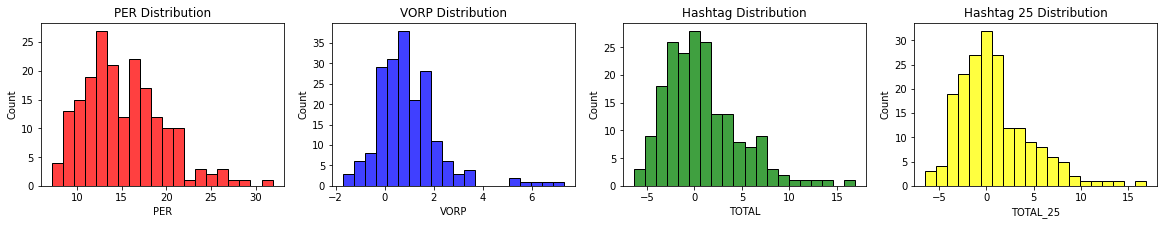

In [13]:
plt.rcParams['figure.figsize'] = [20, 3]

plt.subplot(1,4,1)
sns.histplot(data['PER'], bins = 20, color = 'red')
plt.title('PER Distribution')

plt.subplot(1,4,2)
sns.histplot(data['VORP'], bins = 20, color = 'blue')
plt.title('VORP Distribution')

plt.subplot(1,4,3)
sns.histplot(data['TOTAL'], bins = 20, color = 'green')
plt.title('Hashtag Distribution')

plt.subplot(1,4,4)
sns.histplot(data['TOTAL_25'], bins = 20, color = 'yellow')
plt.title('Hashtag 25 Distribution')

#### Columns to Alter
We will now like to scale the distributions of the three parameters to map to our stated requirements above. After manually experimenting, I have settled on these alterations

PER - Multiply by 1.3  
VORP - Add 3, multiply by 4  
Hashtag - Add 5, multiply by 2  

In [14]:
data['PER'] = data['PER']*1.3
data['VORP'] = (data['VORP']+2)*3.5+8
data['TOTAL'] = (data['TOTAL']+8)*1.7
data['TOTAL_25'] = (data['TOTAL_25']+8)*1.7

Text(0.5, 1.0, 'Hashtag 25 Distribution')

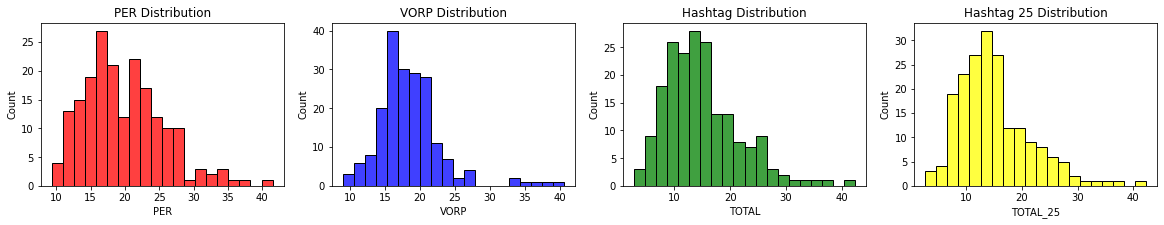

In [15]:
plt.subplot(1,4,1)
sns.histplot(data['PER'], bins = 20, color = 'red')
plt.title('PER Distribution')

plt.subplot(1,4,2)
sns.histplot(data['VORP'], bins = 20, color = 'blue')
plt.title('VORP Distribution')

plt.subplot(1,4,3)
sns.histplot(data['TOTAL'], bins = 20, color = 'green')
plt.title('Hashtag Distribution')

plt.subplot(1,4,4)
sns.histplot(data['TOTAL_25'], bins = 20, color = 'yellow')
plt.title('Hashtag 25 Distribution')

#### Columns to Add
1. FG_miss - Calculate the number of FGs missed per game
2. FT_miss - Calculate the number of FTs missed per game

In [16]:
data['FG_miss'] = data['FGA'] - data['FG']
data['FT_miss'] = data['FTA'] - data['FT']

In [17]:
data.head()

,Player,PER,VORP,FG,FGA,3P,FT,FTA,TRB,AST,STL,BLK,TOV,PTS,TOTAL,TOTAL_25,FG_miss,FT_miss
0,Steven Adams,26.65,22.35,4.5,7.6,0.0,1.9,3.2,9.3,2.3,0.8,1.1,1.5,10.9,15.283,15.402,3.1,1.3
1,Bam Adebayo,26.39,26.55,6.1,11.0,0.0,3.7,5.3,10.2,5.1,1.1,1.3,2.8,15.9,22.780,22.984,4.9,1.6
4,Jarrett Allen,26.91,22.00,4.3,6.6,0.0,2.4,3.9,9.6,1.6,0.6,1.3,1.1,11.1,16.252,15.589,2.3,1.5
7,Kyle Anderson,16.25,18.15,2.3,4.9,0.4,0.8,1.2,4.3,2.4,0.8,0.6,1.0,5.8,9.605,9.010,2.6,0.4
8,Giannis Antetokounmpo,41.47,38.10,10.9,19.7,1.4,6.3,10.0,13.6,5.6,1.0,1.0,3.7,29.5,26.078,28.900,8.8,3.7


#### Capturing Top Players for Each Stat

In [18]:
data.sort_values(by = 'PER', ascending = False)[['Player','PER']].head(20)

,Player,PER
8,Giannis Antetokounmpo,41.47
145,James Harden,37.83
87,Anthony Davis,35.62
206,Kawhi Leonard,34.97
209,Damian Lillard,34.97
106,Joel Embiid,33.54
178,LeBron James,33.15
369,Hassan Whiteside,32.50
384,Trae Young,31.07
75,John Collins,30.55


In [19]:
data.sort_values(by = 'VORP', ascending = False)[['Player','VORP']].head(20)

,Player,VORP
145,James Harden,40.55
8,Giannis Antetokounmpo,38.10
178,LeBron James,36.35
209,Damian Lillard,35.65
87,Anthony Davis,33.90
206,Kawhi Leonard,32.85
290,Chris Paul,27.25
333,Jayson Tatum,26.90
1,Bam Adebayo,26.55
127,Rudy Gobert,26.55


In [20]:
data.sort_values(by = 'TOTAL', ascending = False)[['Player','TOTAL']].head(20)

,Player,TOTAL
145,James Harden,42.279
87,Anthony Davis,37.349
209,Damian Lillard,34.918
206,Kawhi Leonard,33.473
384,Trae Young,30.481
75,John Collins,30.209
36,Devin Booker,28.832
369,Hassan Whiteside,28.169
178,LeBron James,28.033
106,Joel Embiid,26.996


In [21]:
data.sort_values(by = 'TOTAL_25', ascending = False)[['Player','TOTAL_25']].head(20)

,Player,TOTAL_25
145,James Harden,42.279
209,Damian Lillard,37.349
87,Anthony Davis,34.918
206,Kawhi Leonard,33.167
384,Trae Young,31.382
178,LeBron James,30.209
8,Giannis Antetokounmpo,28.900
75,John Collins,28.033
36,Devin Booker,27.778
333,Jayson Tatum,26.996


### Performing Linear Regression

#### Choosing Our Parameters

Generally, in this scoring setting of fantasy basketball, I have seen these five stats commonly used for scoring
- TRB
- AST
- STL
- BLK
- PTS 

The list here are sometimes used depending on league preference
- 3P
- FG, FGA, FG_miss
- FT, FTA, FT_miss
- TOV

As an initial run, I will use eight parameters (TRB, AST, STL, BLK, PTS, FGA, FTA, TOV). This will include the common five parameters, and add penalties for attempting FGs, FTs, and TOVs, in which the values will be negative. By including penalties for attempting FGs and FTs, it will include a point bonus for making a 3 point attempt, and cause FG% and FT% to have a factor on the scoring.

### Attempt 1: Initial Regressions
We will use a simple multivariate linear regression and extract the coefficients which will be our parameters

#### Attempt 1a: PER

In [22]:
cols = ['FGA','FTA','TRB','AST','STL','BLK','TOV','PTS']

In [23]:
model = LinearRegression(fit_intercept=False)
model.fit(data[cols],data['PER'])
PER_coef = model.coef_

#### Attempt 1b: VORP

In [24]:
model = LinearRegression(fit_intercept=False)
model.fit(data[cols],data['VORP'])
VORP_coef = model.coef_

#### Attempt 1c: Hashtag

In [25]:
model = LinearRegression(fit_intercept=False)
model.fit(data[cols],data['TOTAL'])
Hashtag_coef = model.coef_

#### Attempt 1d: Hashtag Weighted

In [26]:
model = LinearRegression(fit_intercept=False)
model.fit(data[cols],data['TOTAL_25'])
Hashtag25_coef = model.coef_

#### Visualize Attempt 1 Results

In [27]:
attempt1 = pd.DataFrame([PER_coef,VORP_coef,Hashtag_coef,Hashtag25_coef],columns = cols, index = ['PER','VORP','Hashtag','Hashtag25'])
attempt1 = attempt1.round(2)
attempt1

,FGA,FTA,TRB,AST,STL,BLK,TOV,PTS
PER,-1.61,-1.02,1.25,1.56,3.55,3.10,-3.66,2.24
VORP,-1.71,-1.44,1.01,1.86,6.36,1.77,-4.69,2.31
Hashtag,-2.23,-1.47,0.19,0.86,3.77,3.26,-0.21,2.61
Hashtag25,-1.50,-1.06,0.23,0.86,2.97,2.40,-0.06,2.02


#### Attempt 1 Learnings

From the average stats per game, we know around what values to expect. Additionally, this is what fantasy players will expect when playing as well.
- TRB, AST, STL, BLK, and PTS should all be positive
- FGA, FTA, TOV should be negative
- TRB and AST should be around the same value
- STL and BLK should be around the same value
- Absolute value of TOV should be similar to AST

PER is the current best correlation, satisying most of the 5 conditions above. The only caveat is that TOV is a very high penalty  
VORP has a very high score for STLs, but not for BLKs. It also has a high penalty for TOV.  
Hashtag becomes a bit more balanced, however it is greatly undervaluing rebounds
  
To improve on this, I will be adding bounds for these parameters in my second attempt.

In [28]:
def func(data, FGA, FTA, TRB, AST, STL, BLK, TOV, PTS):
    return FGA*data['FGA'] + FTA*data['FTA'] + TRB*data['TRB'] + AST*data['AST'] + STL*data['STL'] + BLK*data['BLK'] + TOV*data['TOV'] + PTS*data['PTS']

In [29]:
initialParameters = [-1, -1, 1, 1, 2, 2, -1, 2]
lowerBounds = [-3, -3, 0.8, 0.5, 1, 2, -2, 0]
upperBounds = [0, 0, 2, 2, 2, 3, 0, 5]
parameterBounds = [lowerBounds, upperBounds]

In [30]:
fittedParameters, pcov = curve_fit(func, data[cols], data['PER'], p0 = initialParameters, bounds = parameterBounds)
PER_coef2 = fittedParameters

In [31]:
fittedParameters, pcov = curve_fit(func, data[cols], data['VORP'], p0 = initialParameters, bounds = parameterBounds)
VORP_coef2 = fittedParameters

In [32]:
fittedParameters, pcov = curve_fit(func, data[cols], data['TOTAL'], p0 = initialParameters, bounds = parameterBounds)
Hashtag_coef2 = fittedParameters

In [33]:
fittedParameters, pcov = curve_fit(func, data[cols], data['TOTAL_25'], p0 = initialParameters, bounds = parameterBounds)
Hashtag25_coef2 = fittedParameters

In [34]:
attempt2 = pd.DataFrame([PER_coef2,VORP_coef2,Hashtag_coef2,Hashtag25_coef2],columns = cols, index = ['PER','VORP','Hashtag','Hashtag25'])
attempt2 = attempt2.round(2)
attempt2

,FGA,FTA,TRB,AST,STL,BLK,TOV,PTS
PER,-1.72,-1.38,1.27,1.40,2.00,3.00,-2.00,2.32
VORP,-1.65,-2.06,0.99,1.80,2.00,2.79,-2.00,2.32
Hashtag,-1.87,-1.29,0.80,1.30,2.00,2.00,-1.43,2.29
Hashtag25,-1.07,-0.80,0.80,1.36,1.69,2.00,-1.58,1.60


#### Visualizing Giannias Antetokuonmpo's 2019-2020 fantasy season with the Hashtag25 model

In [35]:
antetokuonmpo = pd.read_csv('antetokounmpo_2019.csv')

In [36]:
antetokuonmpo.columns

Index(['Rk', 'G', 'Date', 'Age', 'Tm', 'Unnamed: 5', 'Opp', 'Unnamed: 7', 'GS',
       'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GmSc', '+/-'],
      dtype='object')

In [37]:
antetokuonmpo = antetokuonmpo[['FGA','FTA','TRB','AST','STL','BLK','TOV','PTS']]
antetokuonmpo = antetokuonmpo[antetokuonmpo['PTS'].str.isdigit()]
antetokuonmpo = antetokuonmpo.apply(pd.to_numeric)

In [38]:
antetokuonmpo['TOTAL'] = (antetokuonmpo*Hashtag25_coef2).sum(axis=1)

Text(0.5, 0, 'Fantasy Points')

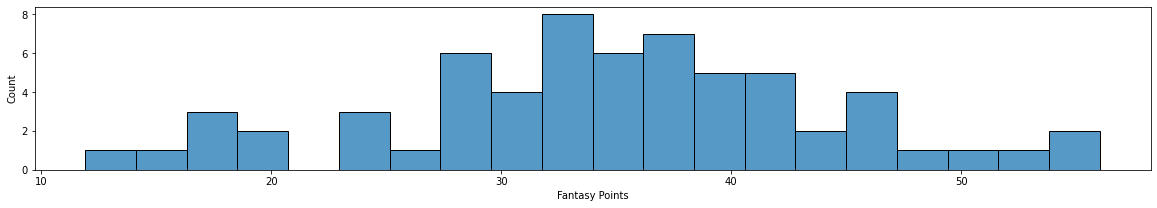

In [40]:
sns.histplot(antetokuonmpo['TOTAL'], bins = 20)
plt.xlabel('Fantasy Points')

### Conclusion

Optimal settings a difficult to assess, as the definition of what is "optimal" is so up in the air. In reality, everyone's ideal settings and how they want to balance the points for each stat will be different. In this project, I initially thought performing multivariate linear regression would give clean settings for stats that are similar to the typical settings for a points for stats style fantasy basketball league. However, the results showed that it can stray far from that to produce useful results.

The benefit from performing a regression like this, is that you are able to add stats like "FGA", "FTA" or any other stats that are not intuitive to know what their points should immediately be worth, and how they would balance out other steps. However, without adding restrictions, variables have a good chance of becoming numbers that are not ideal for fantasy basketball (like losing points for rebounds).

### Potential Future Steps

Reducing overfitting?  
The outputs that I am seeing is imbalanced to what the typical fantasy settings are. Perhaps the model is overfitting, and adding regularization would help achieve balance.

Creation of custom tool with UI  
As explained earlier, because everyone will have a different definition of what "optimal" settings is, it is difficult to produce a setting that will work for everyone. From my view, the most impactful path forward would be to add flexibility and make this an interactive tool for users to input their own preferences, and the code will output the optimal settings for that specific user. This will allow users to decide which stats they want to include in the scoring settings of their league, and also how they want to add bounds to each stat to balance it in their own preferred way.